Fourth figure of the manuscript, showing Cross-correlation analyses. 
- Fitting results
- brain maps
- correlations of spatial parameter b with timescales for LFP and gamma

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from copy import deepcopy
import pandas as pd
import numpy as np
from scipy.stats import bootstrap, ttest_rel, false_discovery_control
import matplotlib.pyplot as plt
import mne
import nilearn
from nilearn import surface as nisurf

from mnitimescales import plots, utils

plots._set_font_params()

Imports and definitions:

In [3]:
stages = ["W", "N3", "R"]
stage_colors = {"W": "red", "N2": "cyan", "N3": "purple", "R": "green"}
title_dict = {"W": "Wake", "N2": "NREM2", "N3": "NREM3", "R": "REM"}
corr_type = "pearson"

# Paths
data_path = Path("F:\\MNIOpen")
sc_path = data_path.joinpath("Results", "test_sc_broadband")
tau_path = data_path.joinpath("Results", "timescales_broadband")
fig_path = data_path.joinpath("Figures", "Fig_sc_broadband")
fig_path.mkdir(exist_ok=True, parents=True)

# Parcellation
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "aparc.a2009s"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
labels_mne = mne.read_labels_from_annot(
    "fsaverage", parc_map_name, "lh", subjects_dir=subjects_dir
)
df_mnia_dest = pd.read_excel(
    data_path.joinpath("Data", "Parcellation", "mnia_Destrieux_labels.xlsx"),
    index_col=0,
)
df_mnia_dest["Destrieux atlas name"] = df_mnia_dest["Destrieux atlas name"].str.strip(
    "'"
)
df_mnia_dest.rename(
    columns={
        "Destrieux atlas name": "Destrieux",
        "MNIA equivalent": "MNIA",
    },
    inplace=True,
)
df_mnia_dest.drop(columns="Expanded name", inplace=True)

Reading labels from parcellation...
   read 75 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\lh.aparc.a2009s.annot


SC results and parameters:

In [4]:
# Dataframe with data on all channles pairs
df_sc_stages = {
    stage: pd.read_csv(sc_path.joinpath(f"sc_{stage}.csv"), index_col=0)
    for stage in stages
}
# Dataframe with the fit parameters on correlation
df_params_corr_stages = {
    stage: pd.read_csv(sc_path.joinpath(f"sc_params_{stage}_fit_corr.csv"), index_col=0)
    for stage in stages
}

# Dataframe with timescales for all electrodes
df_timescales = pd.read_csv(tau_path.joinpath("tau_stages.csv"), index_col=0)

### A) Plot Correlation vs distance plots 

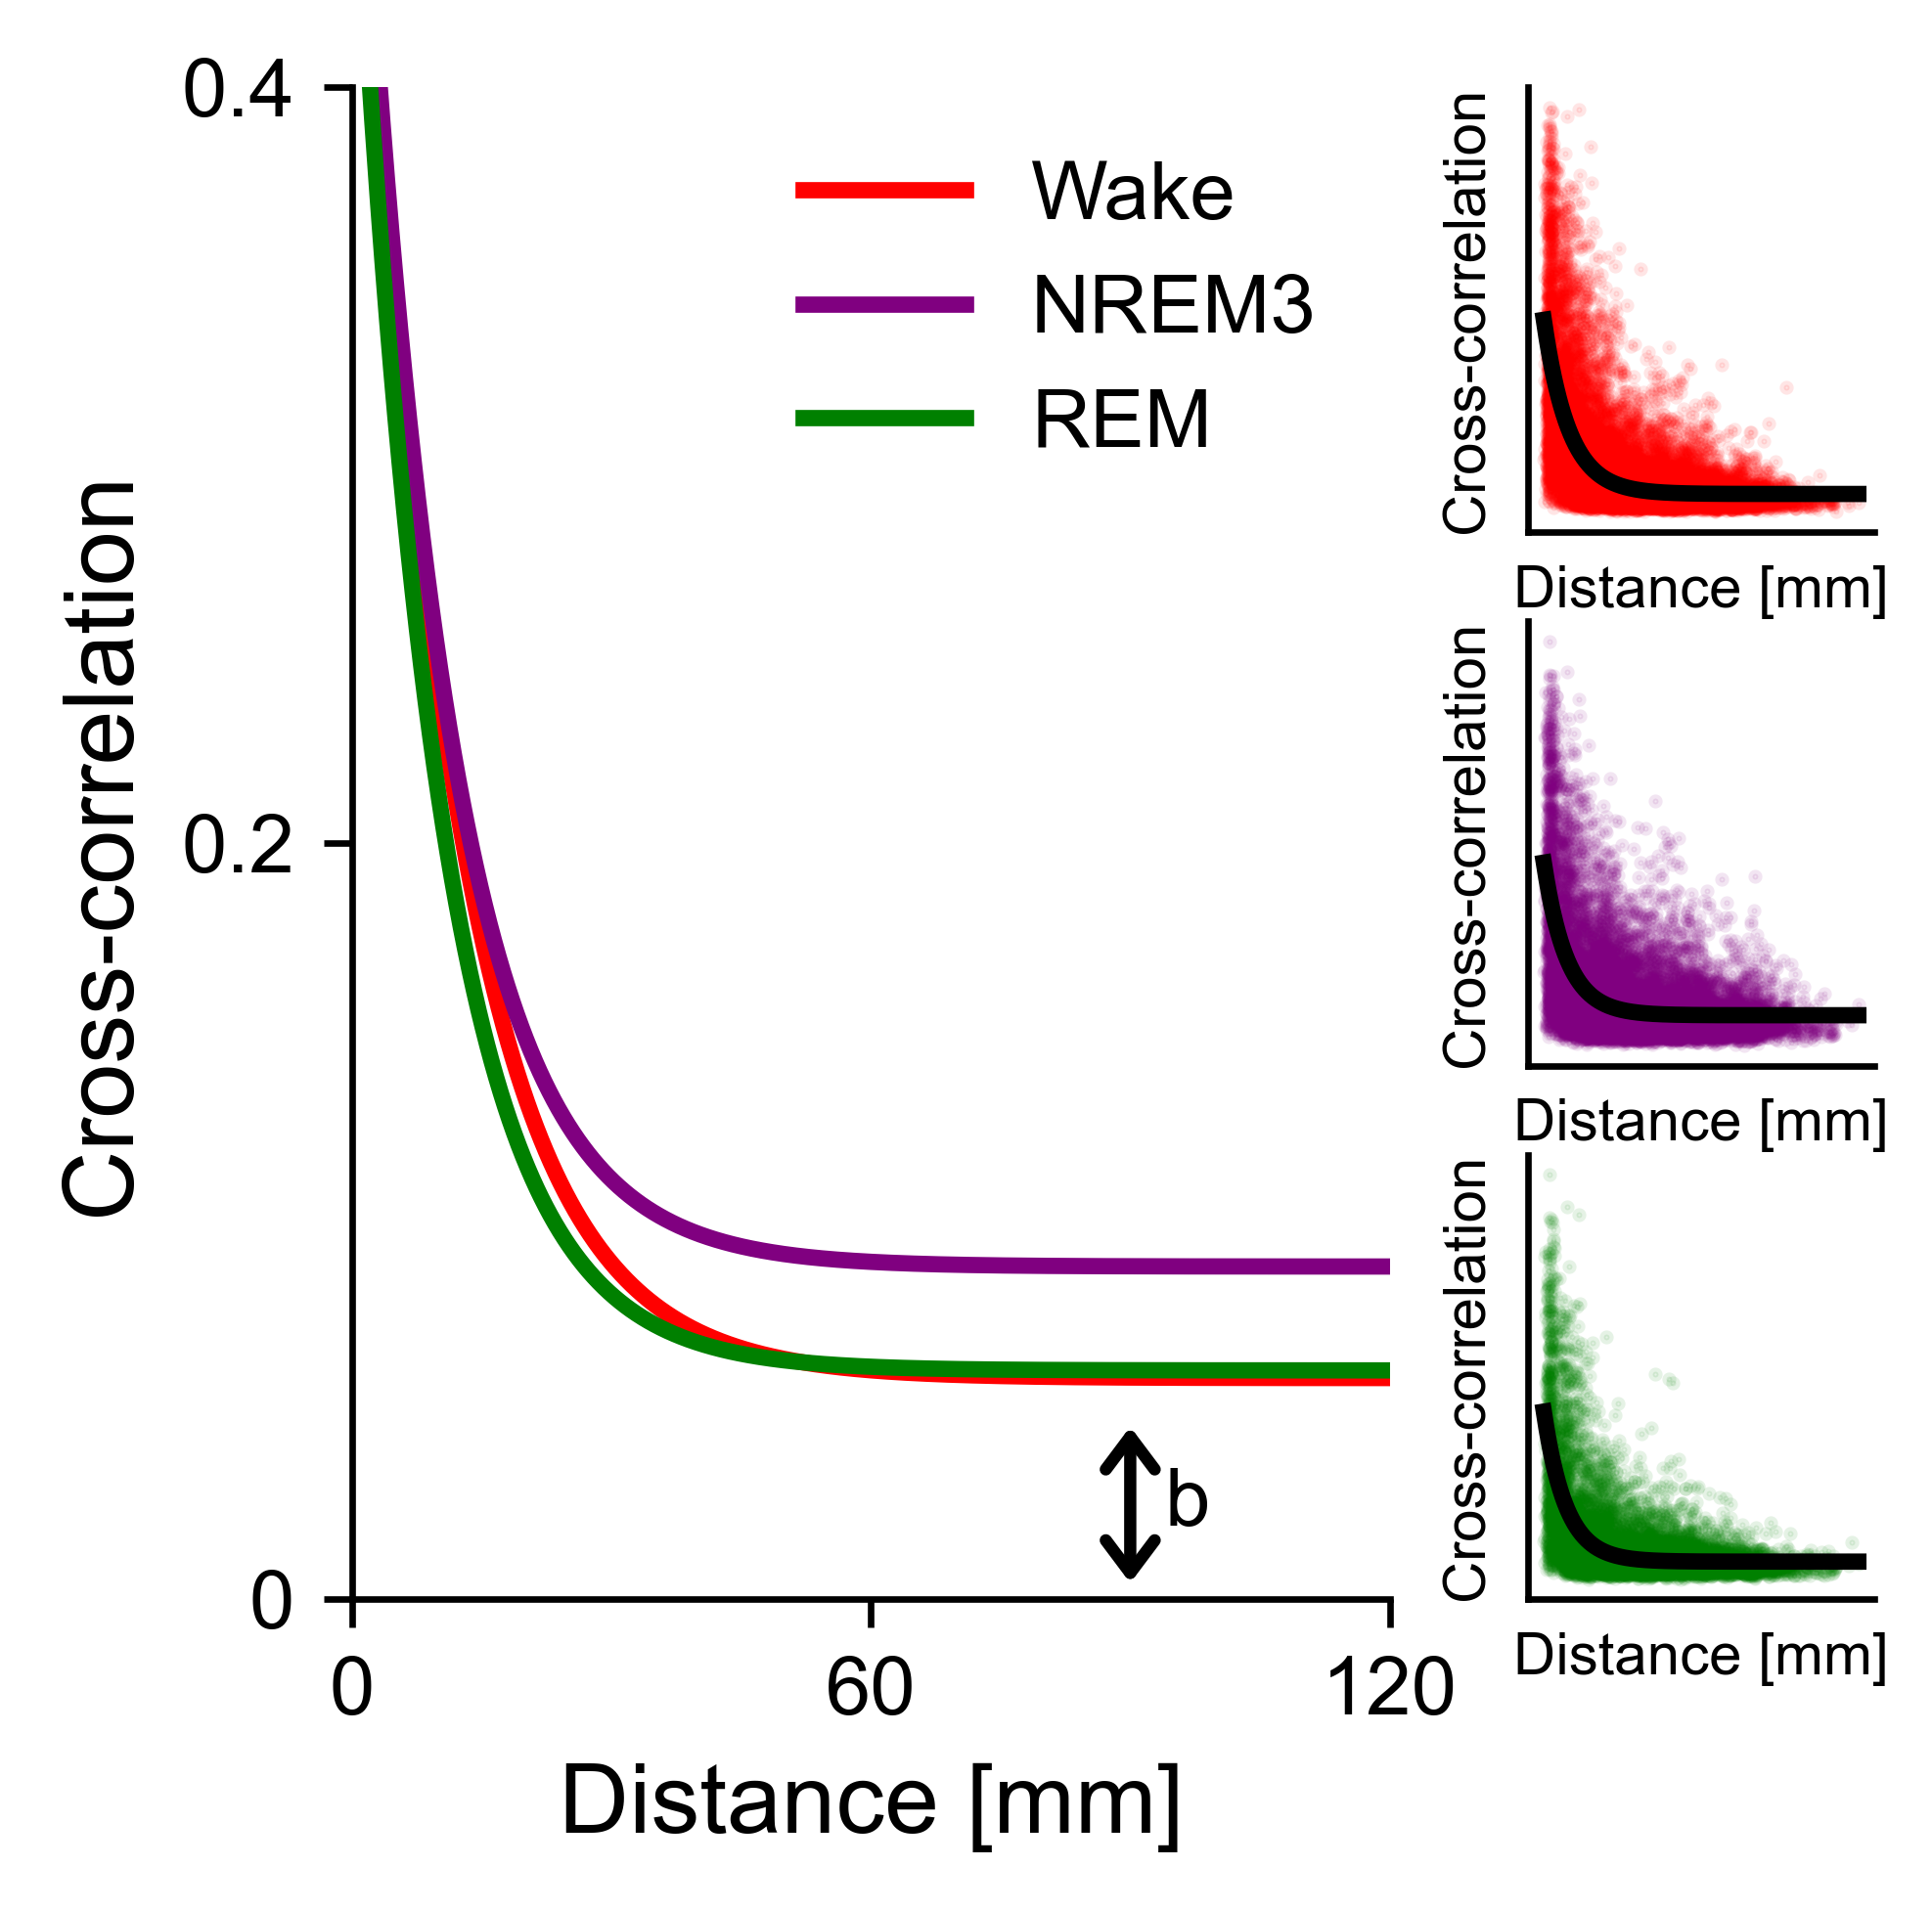

In [5]:
params_stages = {
    stage: par.loc["all"].to_numpy().squeeze()
    for stage, par in df_params_corr_stages.items()
}

fig, axs = plots.plot_sc_fit(
    df_sc_stages,
    params_stages,
    stage_colors,
    dict_stages=title_dict,
    figsize=(8.5, 8.5),
)

# Adjust plot
axs[0].set_xlim(0, 120)
axs[0].set_ylim(0, 0.4)
axs[0].set_xticks([0, 60, 120], labels=[0, 60, 120], fontsize=plots.fsize.TICK_SIZE)
axs[0].set_yticks([0, 0.2, 0.4], labels=[0, 0.2, 0.4], fontsize=plots.fsize.TICK_SIZE)
# Annotate b parameter
axs[0].annotate(
    "",
    xy=(90, 0.05),
    xytext=(90, 0),
    arrowprops=dict(arrowstyle="<->, head_width=0.3", linewidth=1.5),
)
axs[0].annotate("b", xy=(94, 0.025), va="center", fontsize=plots.fsize.TEXT_SIZE)

# Save figure to svg
plots.save_figure(fig, fig_path.joinpath("Fit_stages_corr.svg"))

plt.show()

### C) Average increase of during sleep

Correlation parameters:

diff W - N3 : 0.0249942538713258 4.2102141394875054e-12
diff W - R : 0.00030068081764086127 0.8894851880731136


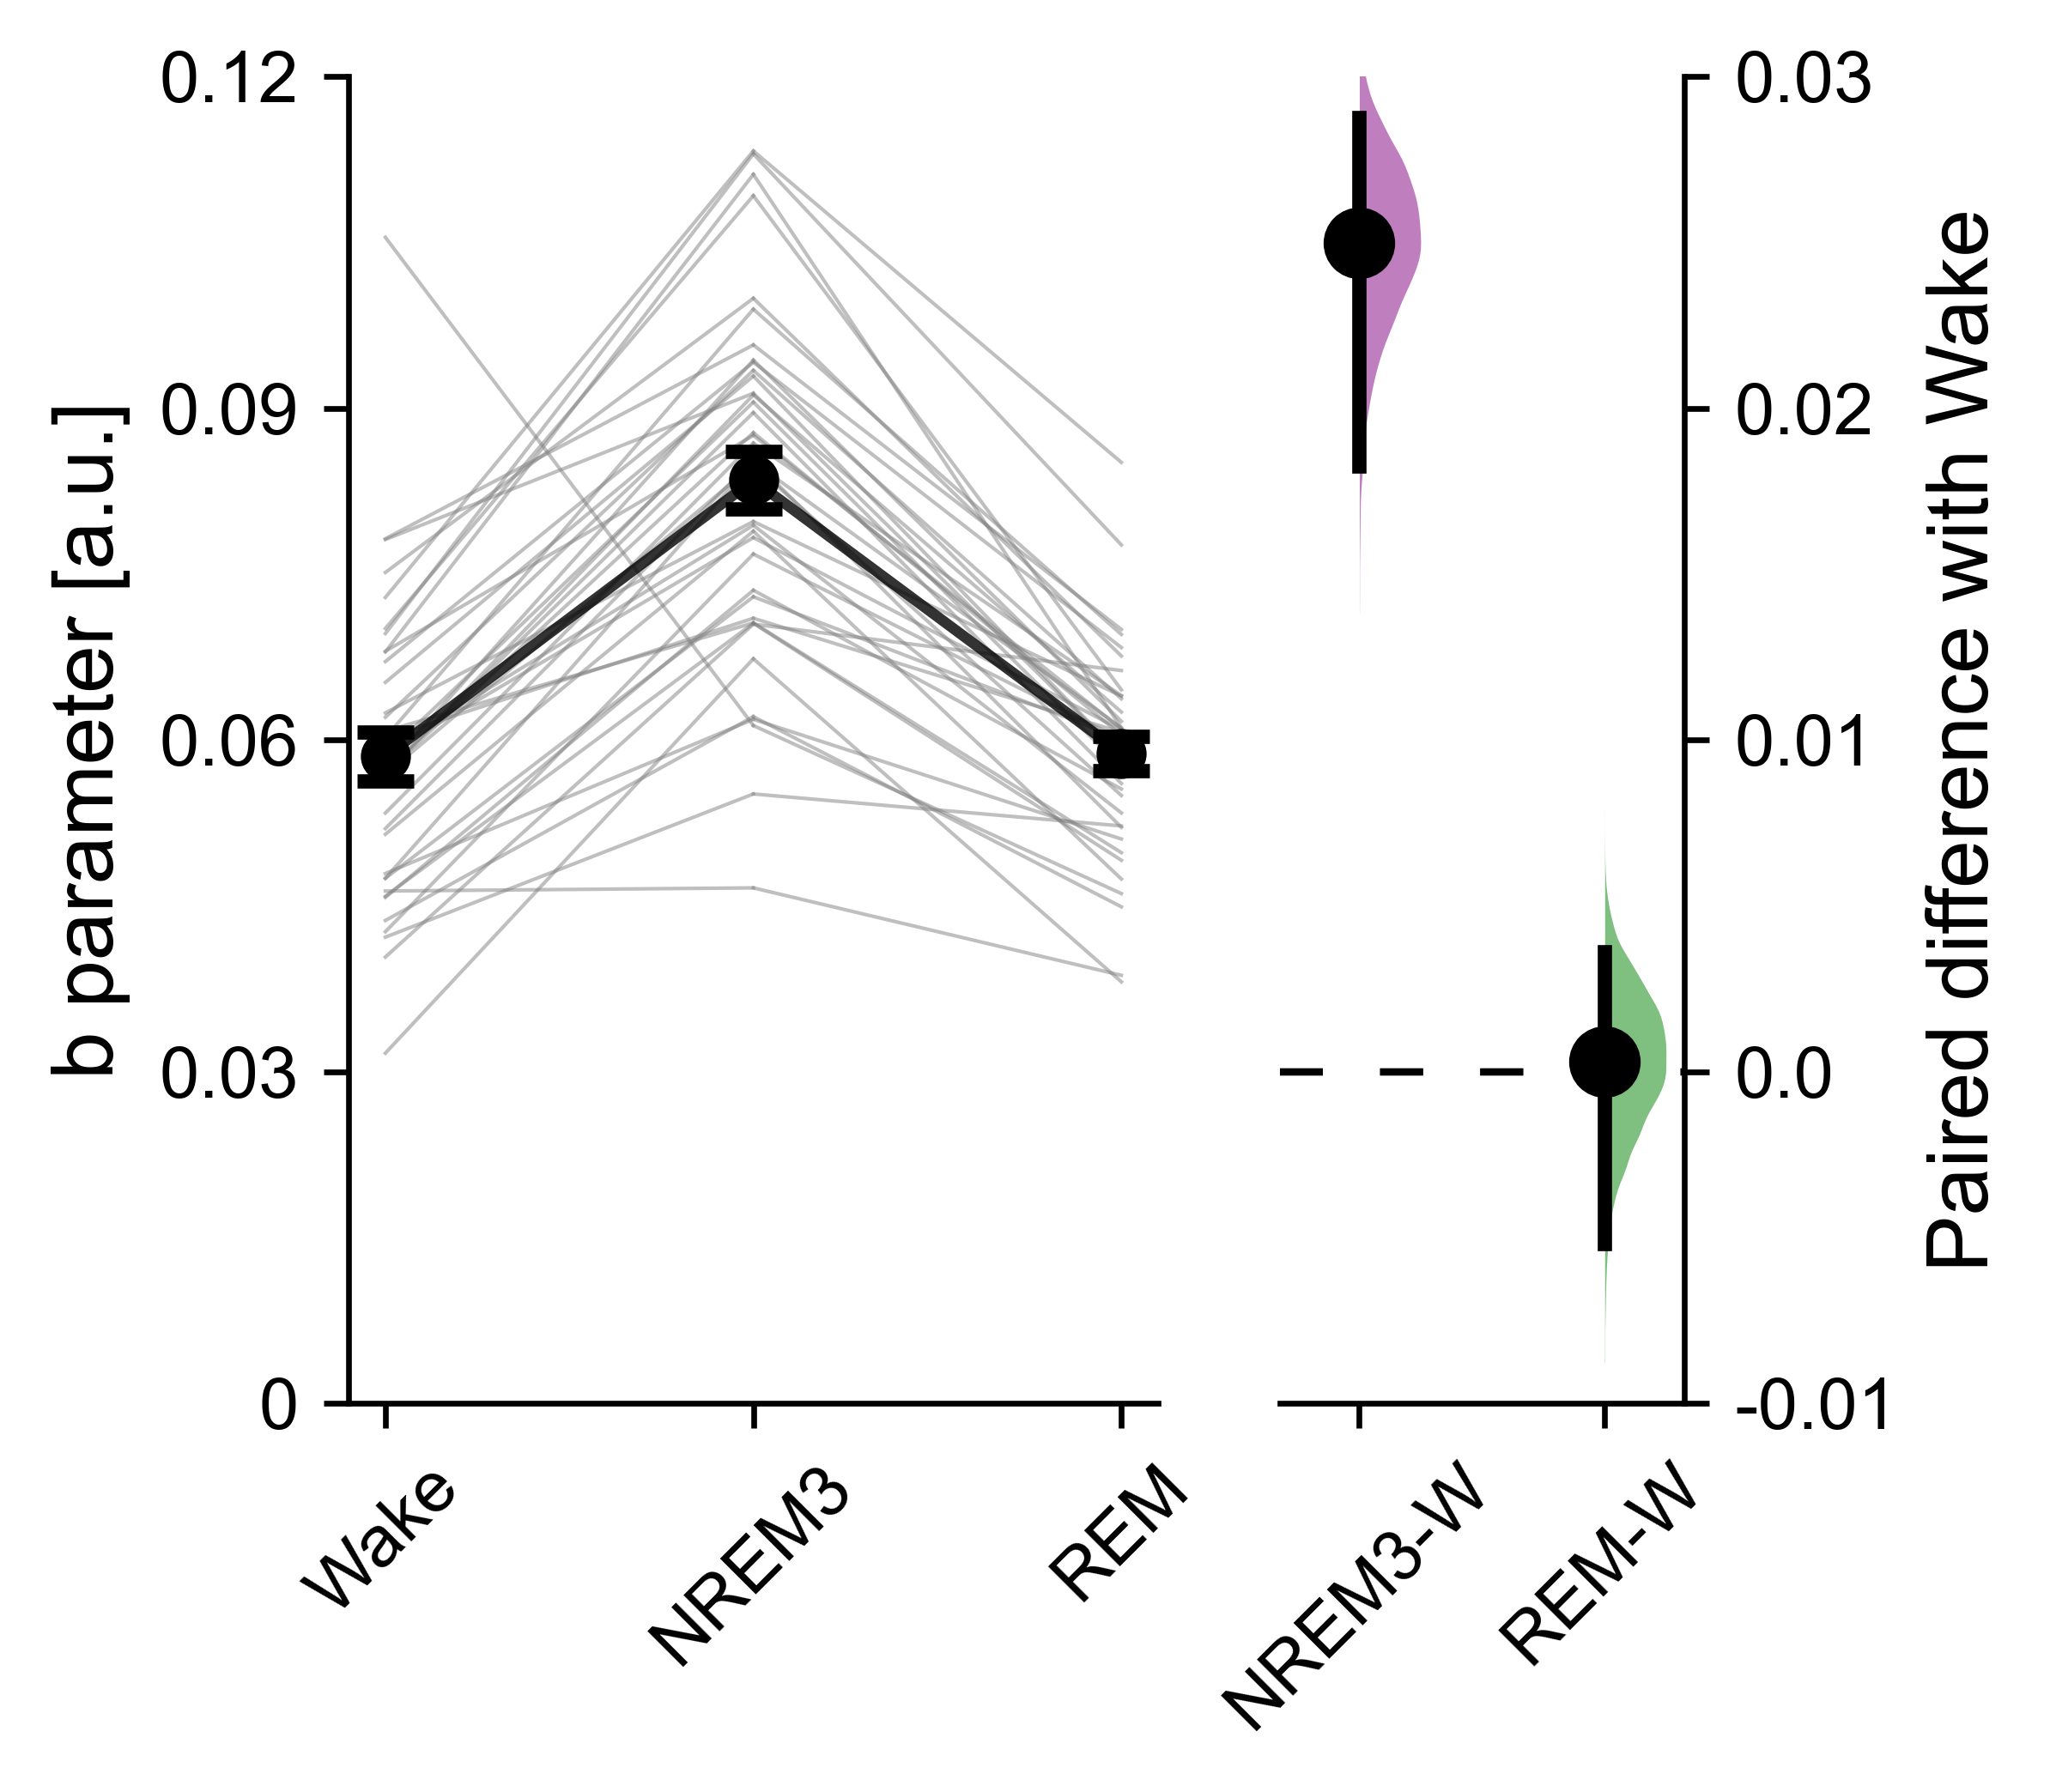

In [10]:
# Prepare dataframe for plotting
df_plot = deepcopy(df_params_corr_stages)
for stage in stages:
    df_plot[stage]["stage"] = stage
df_plot = pd.concat([df.iloc[1:] for df in df_plot.values()])
df_plot = df_plot.pivot(columns="stage", values="b")
df_plot = df_plot[stages]

# Figure
fig, axs = plt.subplots(
    1,
    2,
    figsize=plots._get_figsize_inches((8.5, 8.5)),
    width_ratios=[2, 1],
    dpi=600,
)

# Slope plot
axs[0] = plots.slope_plot(axs[0], df_plot)
# Plot parameters
axs[0].set_ylabel("b parameter [a.u.]", fontsize=plots.fsize.LABEL_SIZE)
axs[0].set_ylim(0.0, 0.12)
axs[0].set_yticks(
    [0, 0.03, 0.06, 0.09, 0.12],
    labels=[0, 0.03, 0.06, 0.09, 0.12],
    fontsize=plots.fsize.TICK_SIZE,
)
axs[0].set_xticks(
    range(len(stages)),
    [title_dict[stage] for stage in stages],
    rotation=45,
    ha="center",
    fontsize=plots.fsize.TICK_SIZE,
)


# Add contrasts
def avg_diff(x, y):
    return np.mean(x - y)


# Plot differences
for i, stage in enumerate(stages[1:]):
    avg = avg_diff(df_plot[stage], df_plot["W"])
    pval = ttest_rel(df_plot[stage], df_plot["W"])[1]
    p_str = f"p = {pval:.2f}" if pval >= 0.001 else "p < 0.001"
    p_str += "*" if pval < 0.05 else ""
    print("diff W -", stage, ":", avg, pval)
    res_boot = bootstrap(
        (df_plot[stage], df_plot["W"]),
        avg_diff,
        paired=True,
        random_state=290496,
    )

    axs[1] = plots.half_violin_plot(
        axs[1],
        avg,
        x_pos=i,
        ci=list(res_boot.confidence_interval),
        y_boot=res_boot.bootstrap_distribution,
        color=stage_colors[stage],
        pval=None,
    )
# Plot parameters
axs[1].set_ylabel("Paired difference with Wake", fontsize=plots.fsize.LABEL_SIZE)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_ylim(-0.01, 0.03)
axs[1].set_yticks(
    [-0.01, 0.0, 0.01, 0.02, 0.03],
    labels=[-0.01, 0.0, 0.01, 0.02, 0.03],
    fontsize=plots.fsize.TICK_SIZE,
)
axs[1].set_xticks(
    range(len(stages) - 1),
    [title_dict[stage] + "-W" for stage in stages[1:]],
    rotation=45,
    fontsize=plots.fsize.TICK_SIZE,
)
axs[1].spines[["top", "left"]].set_visible(False)

# Save figure
plots.save_figure(fig, fig_path.joinpath(f"b_change_stages.svg"))
plt.show()

### D) Correlation with Timescales

In [11]:
map_coords = pd.read_csv(
    data_path.joinpath("Data", "Parcellation", "mnia_centroids_coords.csv"), index_col=0
)

Correlation:

In [12]:
# Gather all p-values to correct
df_rhos = pd.DataFrame(index=["k", "a", "b"], columns=stages, dtype=float)
df_pvals = pd.DataFrame(index=["k", "a", "b"], columns=stages, dtype=float)
rhos_boot = {stage: {} for stage in stages}

# Plot one figure per parameter
for i, stage in enumerate(stages):

    # Get average tau per MNI region
    df_tau_stage_mni = utils.get_avg_tau_mni(
        df_timescales[df_timescales["stage"] == stage].copy(), method="LME"
    )

    for param in ["k", "a", "b"]:

        print(f"Stage: {stage}, Param: {param}")

        # Get spatial parameter
        df_spa = df_params_corr_stages[stage][param].iloc[1:].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Get correlation values
        rho, p_corr = utils.get_pcorr_mnia(
            df_tau_stage_mni, df_spa, map_coords, method="vasa", corr_type="pearson"
        )

        df_rhos.loc[param, stage] = rho
        df_pvals.loc[param, stage] = p_corr
        rhos_boot[stage][param] = utils.get_rho_boot(
            df_tau_stage_mni, df_spa, corr_type="pearson"
        )


# Correct with FDR correction
pvals_corr = false_discovery_control(df_pvals.to_numpy().ravel())
df_pvals_corr = pd.DataFrame(
    pvals_corr.reshape(df_pvals.shape), index=df_pvals.index, columns=df_pvals.columns
)

Stage: W, Param: k
Generating 1000 permutations...
Stage: W, Param: a
Generating 1000 permutations...
Stage: W, Param: b
Generating 1000 permutations...
Stage: N3, Param: k
Generating 1000 permutations...
Stage: N3, Param: a
Generating 1000 permutations...
Stage: N3, Param: b
Generating 1000 permutations...
Stage: R, Param: k
Generating 1000 permutations...
Stage: R, Param: a
Generating 1000 permutations...
Stage: R, Param: b
Generating 1000 permutations...


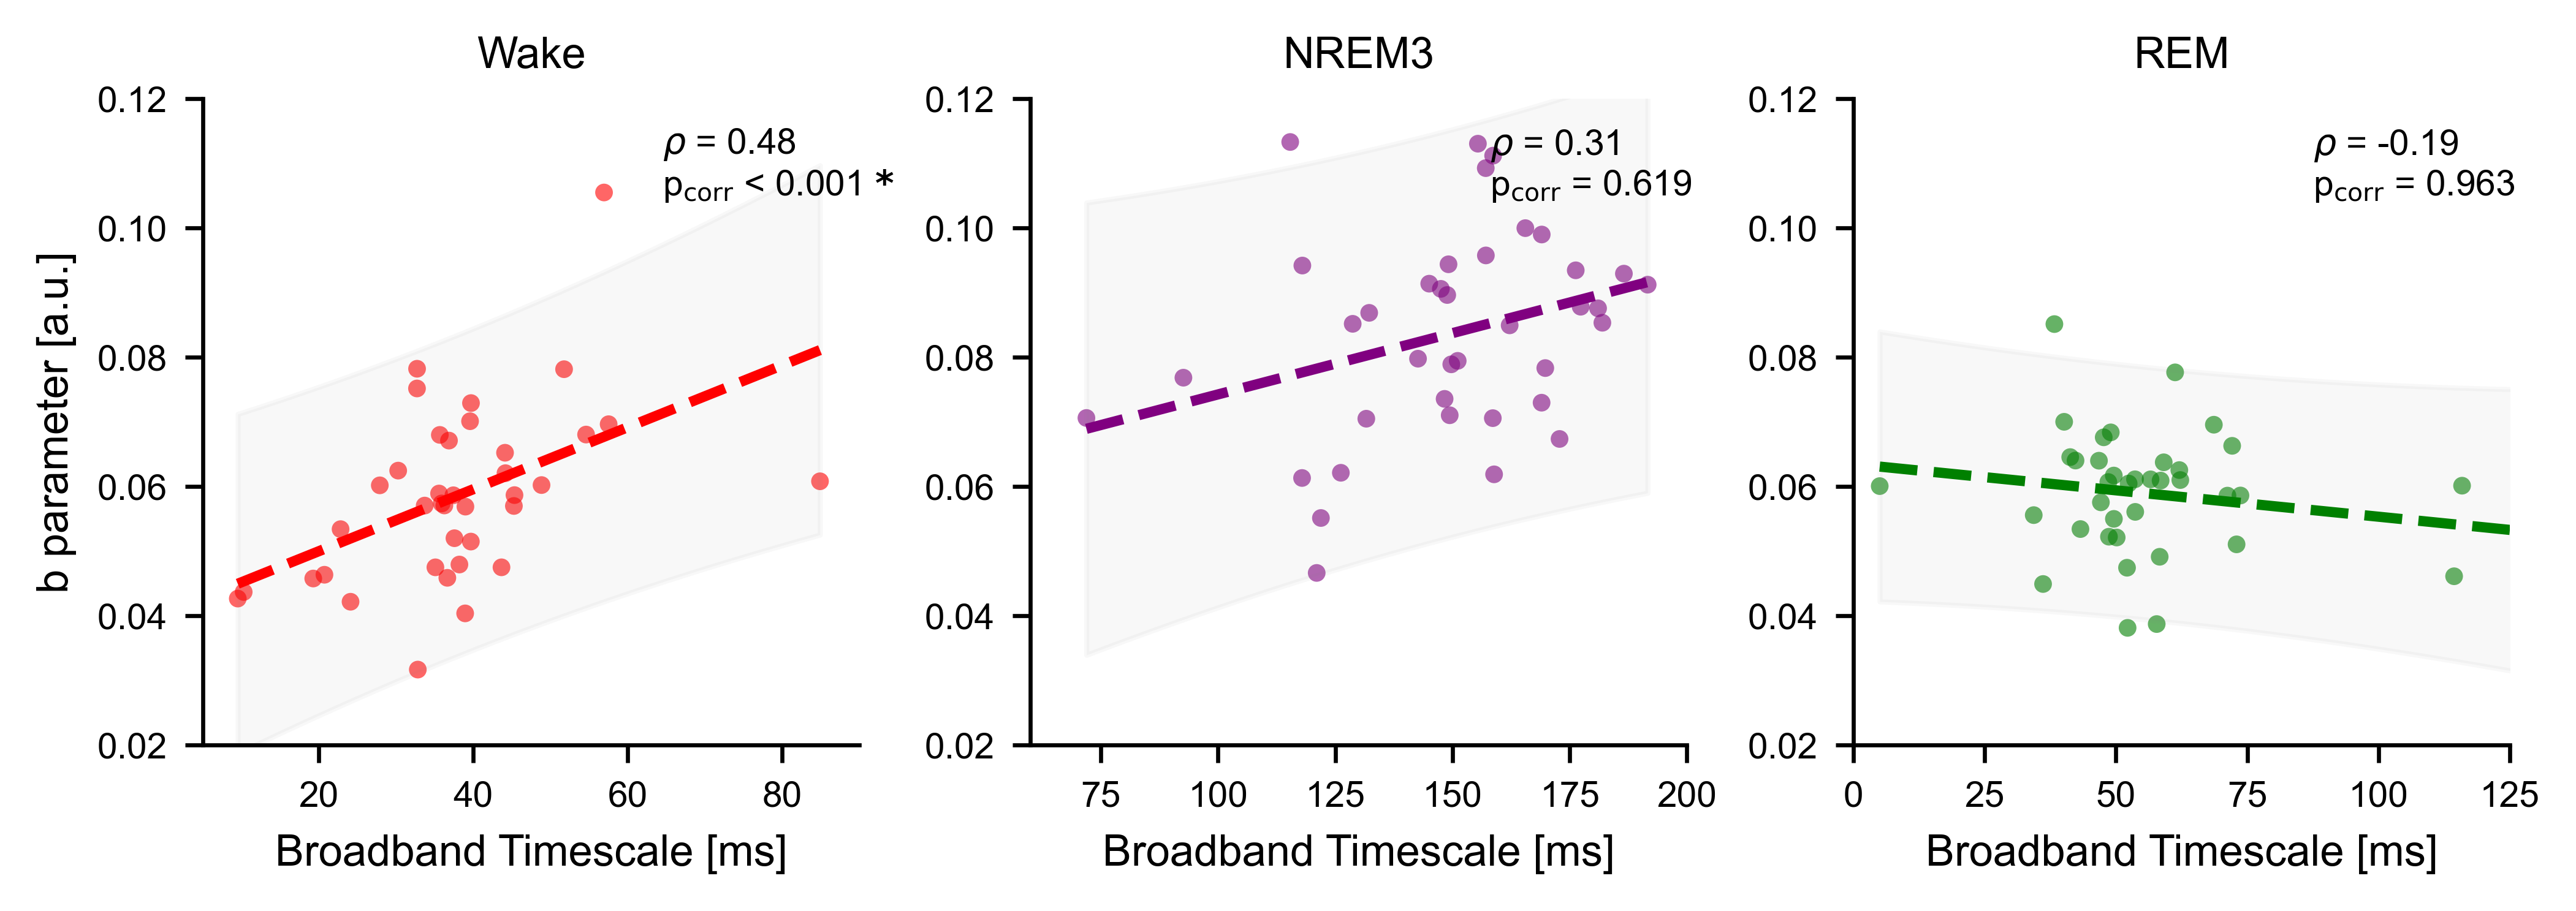

In [14]:
xlims_stages = {"W": (5, 90), "N3": (60, 200), "R": (0, 125)}
ylims_stages = {"W": (0.02, 0.12), "N3": (0.02, 0.12), "R": (0.02, 0.12)}

# Define figure
fig, axs = plt.subplots(
    1, 3, figsize=plots._get_figsize_inches((17.5, 6)), dpi=600, layout="constrained"
)

# One subplot per stage
for i, stage in enumerate(stages):

    # Get average tau per MNI region
    df_tau_stage_mni = utils.get_avg_tau_mni(
        df_timescales[df_timescales["stage"] == stage].copy(), method="LME"
    )

    # Get spatial parameter
    df_spa = df_params_corr_stages[stage]["b"].iloc[1:].astype(float)
    df_spa = df_spa.loc[df_tau_stage_mni.index]

    # Plot
    axs[i] = plots.plot_corr(
        axs[i],
        df_tau_stage_mni.to_numpy().squeeze(),
        df_spa.to_numpy().squeeze(),
        df_rhos.loc[param, stage],
        df_pvals_corr.loc[param, stage],
        color=stage_colors[stage],
        title=title_dict[stage],
        xlabel="Broadband Timescale [ms]",
        ylabel=f"b parameter [a.u.]",
        xlims=xlims_stages[stage],
        ylims=ylims_stages[stage],
    )
    if i > 0:
        axs[i].set_ylabel("", fontsize=0)

# Save figure
plots.save_figure(fig, fig_path.joinpath(f"tau_b_corr.svg"))
plt.show()

### S1) Use median values instead of fit

In [15]:
# Dataframe with the fit parameters on correlation
df_params_corr_avg_stages = {
    stage: pd.read_csv(
        sc_path.joinpath(f"sc_params_{stage}_median_corr.csv"), index_col=0
    )
    for stage in stages
}

diff W - N3 : 0.02289017023481622 3.4353442918924315e-12
diff W - R : -0.0016602661238611397 0.37541821204345105


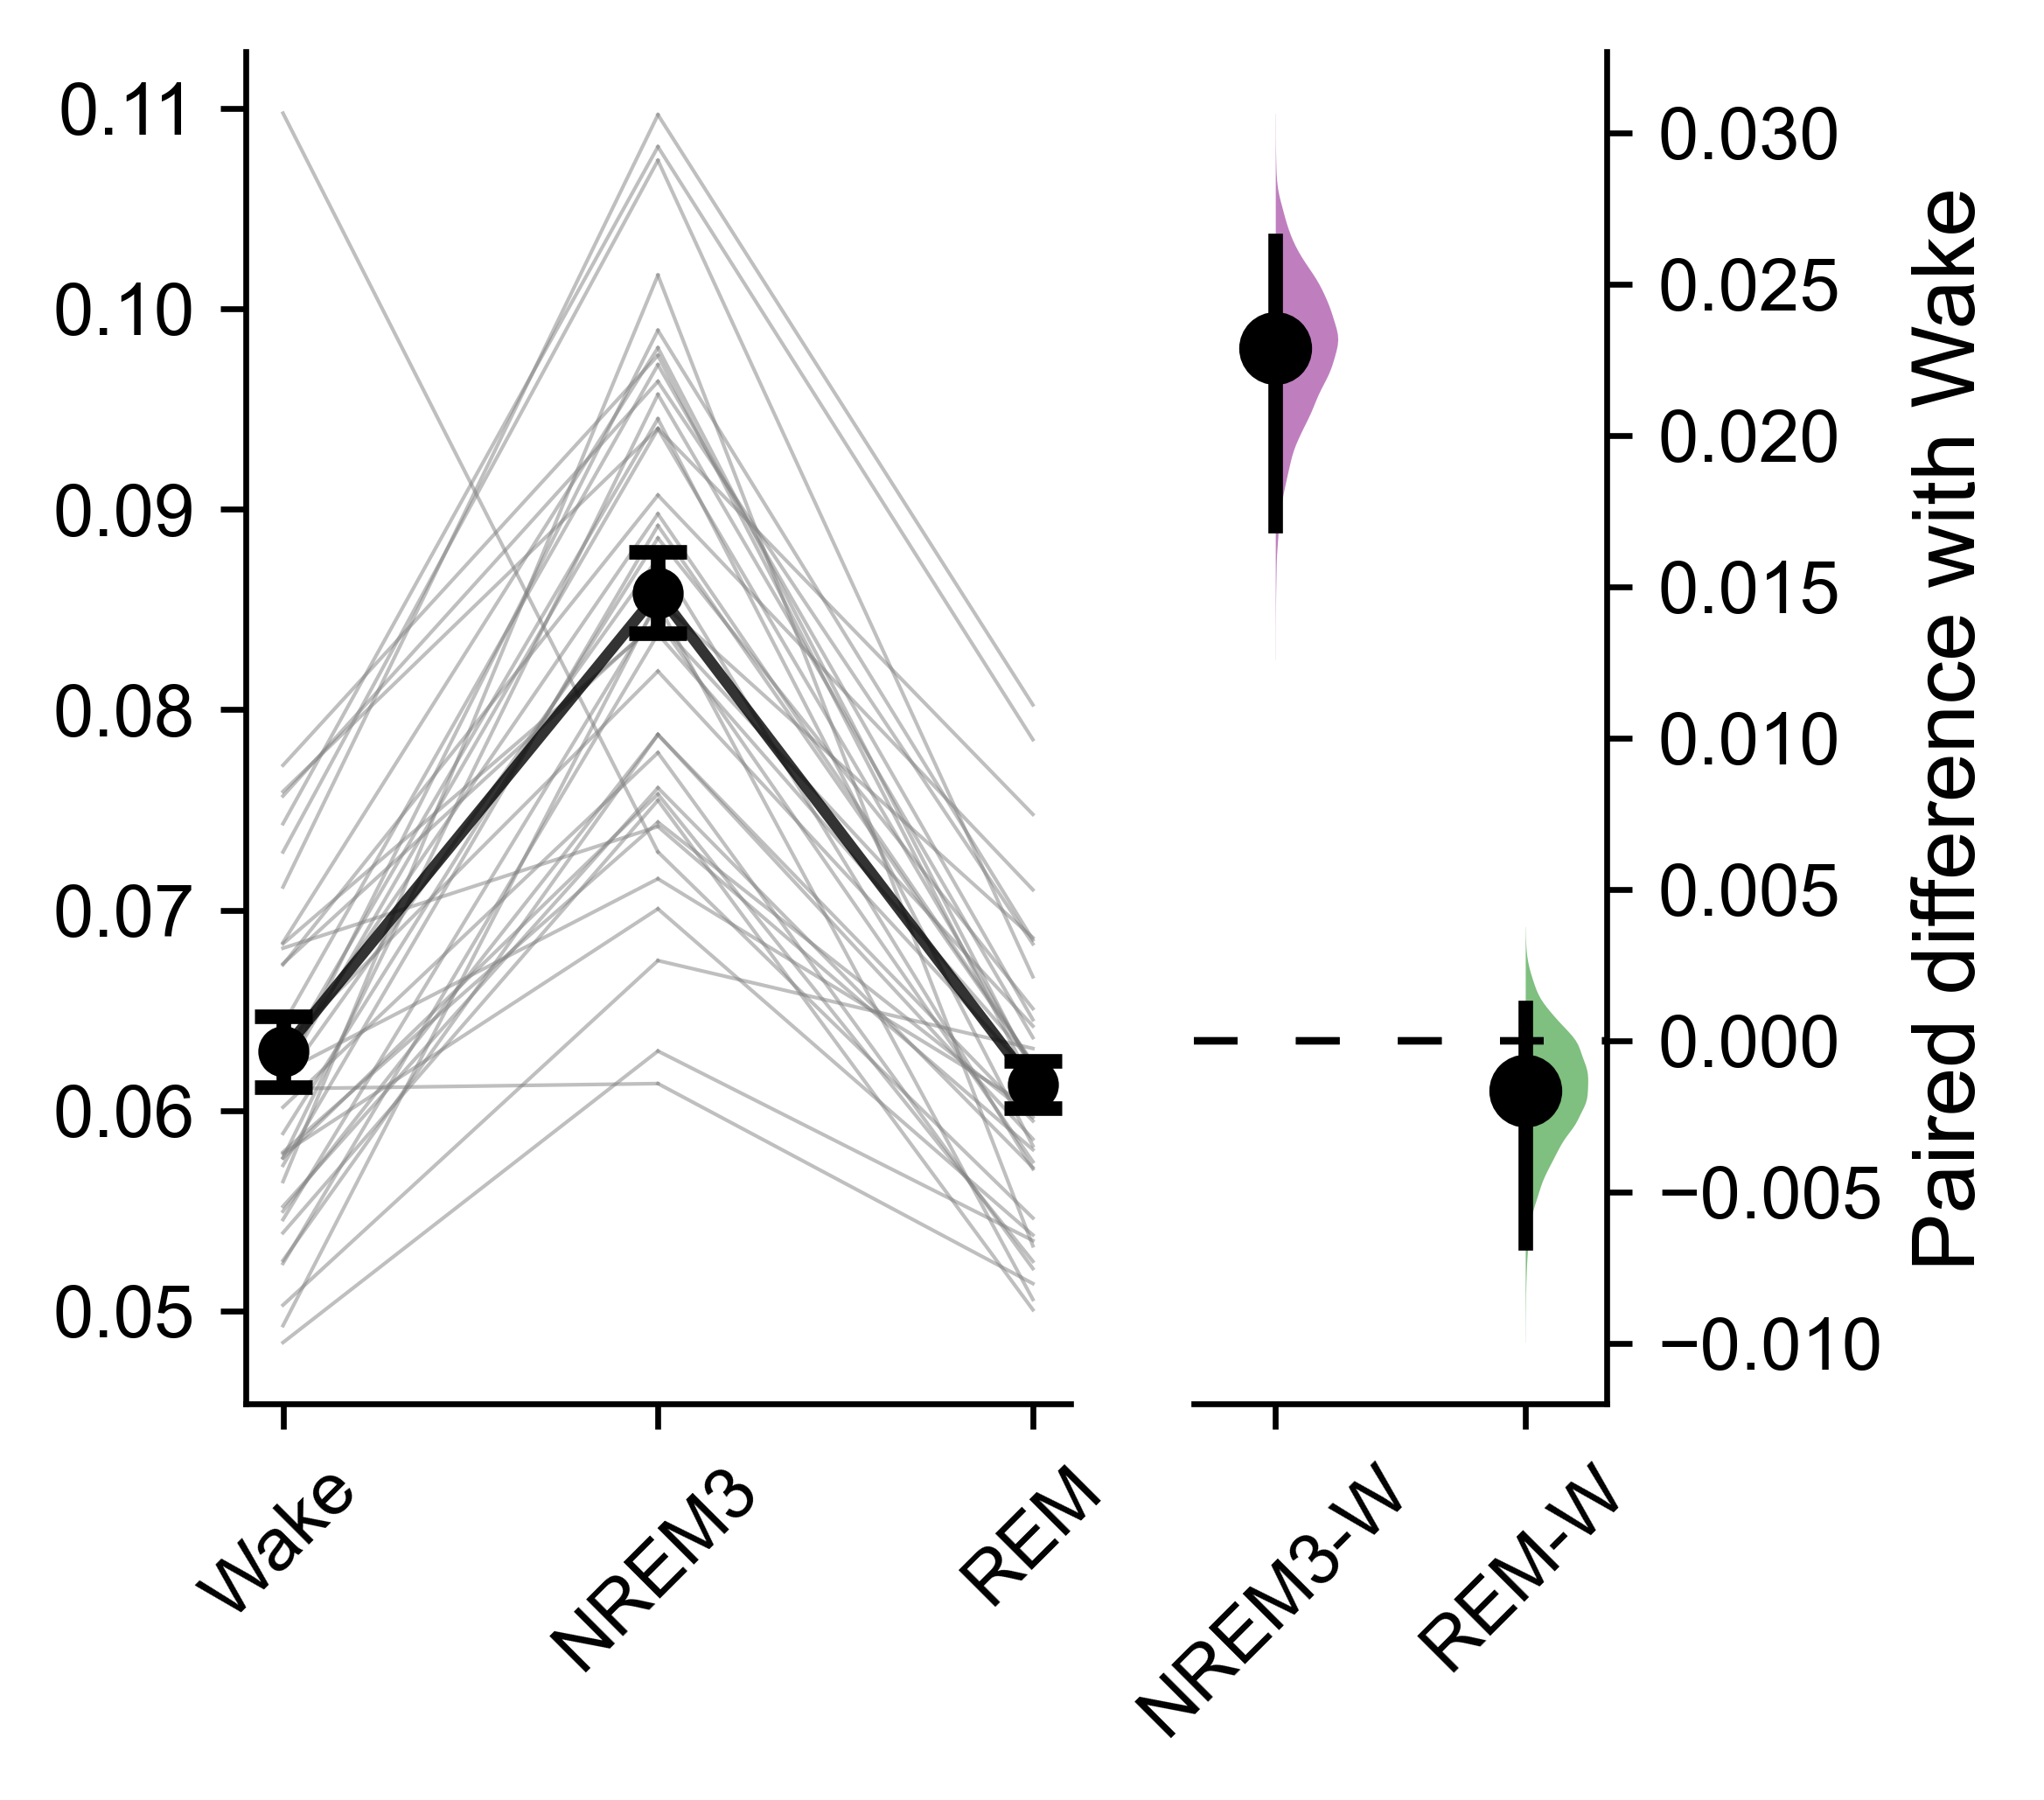

In [16]:
# Prepare dataframe for plotting
df_plot = deepcopy(df_params_corr_avg_stages)
for stage in stages:
    df_plot[stage]["stage"] = stage
df_plot = pd.concat([df.iloc[1:] for df in df_plot.values()])
df_plot = df_plot.pivot(columns="stage", values="avg_high")
df_plot = df_plot[stages]

# Figure
fig, axs = plt.subplots(
    1,
    2,
    figsize=plots._get_figsize_inches((8.5, 8.5)),
    width_ratios=[2, 1],
    dpi=600,
)

# Slope plot
axs[0] = plots.slope_plot(axs[0], df_plot)
# Plot parameters
axs[0].set_xticks(
    range(len(stages)),
    [title_dict[stage] for stage in stages],
    rotation=45,
    ha="center",
    fontsize=plots.fsize.TICK_SIZE,
)


# Add contrasts
def avg_diff(x, y):
    return np.mean(x - y)


# Plot differences
for i, stage in enumerate(stages[1:]):
    avg = avg_diff(df_plot[stage], df_plot["W"])
    pval = ttest_rel(df_plot[stage], df_plot["W"])[1]
    p_str = f"p = {pval:.2f}" if pval >= 0.001 else "p < 0.001"
    p_str += "*" if pval < 0.05 else ""
    print("diff W -", stage, ":", avg, pval)
    res_boot = bootstrap(
        (df_plot[stage], df_plot["W"]),
        avg_diff,
        paired=True,
        random_state=290496,
    )

    axs[1] = plots.half_violin_plot(
        axs[1],
        avg,
        x_pos=i,
        ci=list(res_boot.confidence_interval),
        y_boot=res_boot.bootstrap_distribution,
        color=stage_colors[stage],
        pval=None,
    )
# Plot parameters
axs[1].set_ylabel("Paired difference with Wake", fontsize=plots.fsize.LABEL_SIZE)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_xticks(
    range(len(stages) - 1),
    [title_dict[stage] + "-W" for stage in stages[1:]],
    rotation=45,
    fontsize=plots.fsize.TICK_SIZE,
)
axs[1].spines[["top", "left"]].set_visible(False)

plt.show()

Correlation:

In [17]:
# Gather all p-values to correct
df_rhos = pd.DataFrame(
    index=["avg", "avg_low", "avg_high"], columns=stages, dtype=float
)
df_pvals = pd.DataFrame(
    index=["avg", "avg_low", "avg_high"], columns=stages, dtype=float
)
rhos_boot = {stage: {} for stage in stages}

# Plot one figure per parameter
for i, stage in enumerate(stages):

    # Get average tau per MNI region
    df_tau_stage_mni = utils.get_avg_tau_mni(
        df_timescales[df_timescales["stage"] == stage].copy(), method="LME"
    )

    for param in ["avg", "avg_low", "avg_high"]:

        print(f"Stage: {stage}, Param: {param}")

        # Get spatial parameter
        df_spa = df_params_corr_avg_stages[stage][param].iloc[1:].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Get correlation values
        rho, p_corr = utils.get_pcorr_mnia(
            df_tau_stage_mni, df_spa, map_coords, method="vasa", corr_type="pearson"
        )

        df_rhos.loc[param, stage] = rho
        df_pvals.loc[param, stage] = p_corr
        rhos_boot[stage][param] = utils.get_rho_boot(
            df_tau_stage_mni, df_spa, corr_type="pearson"
        )


# Correct with FDR correction
pvals_corr = false_discovery_control(df_pvals.to_numpy().ravel())
df_pvals_corr = pd.DataFrame(
    pvals_corr.reshape(df_pvals.shape), index=df_pvals.index, columns=df_pvals.columns
)

Stage: W, Param: avg
Generating 1000 permutations...
Stage: W, Param: avg_low
Generating 1000 permutations...
Stage: W, Param: avg_high
Generating 1000 permutations...
Stage: N3, Param: avg
Generating 1000 permutations...
Stage: N3, Param: avg_low
Generating 1000 permutations...
Stage: N3, Param: avg_high
Generating 1000 permutations...
Stage: R, Param: avg
Generating 1000 permutations...
Stage: R, Param: avg_low
Generating 1000 permutations...
Stage: R, Param: avg_high
Generating 1000 permutations...


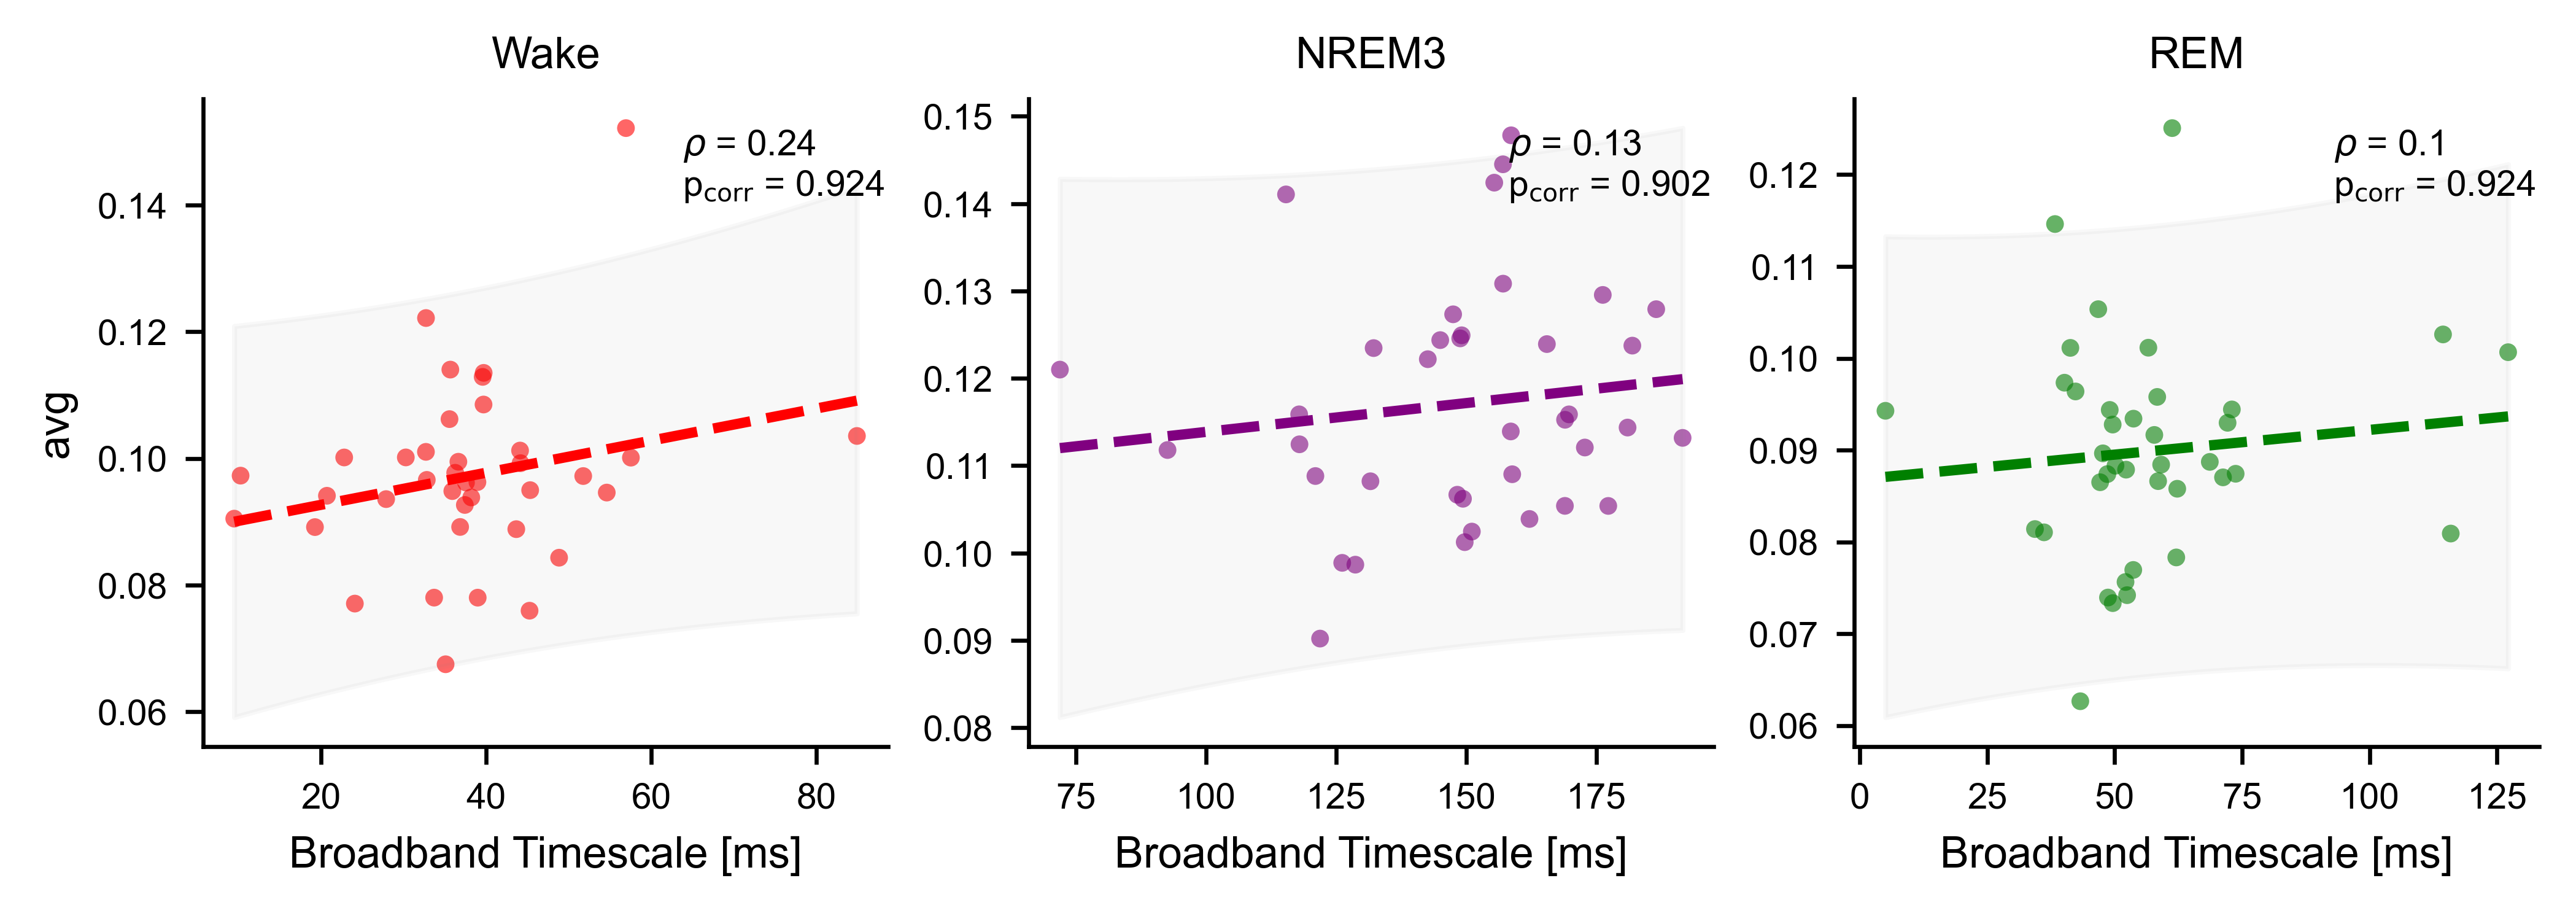

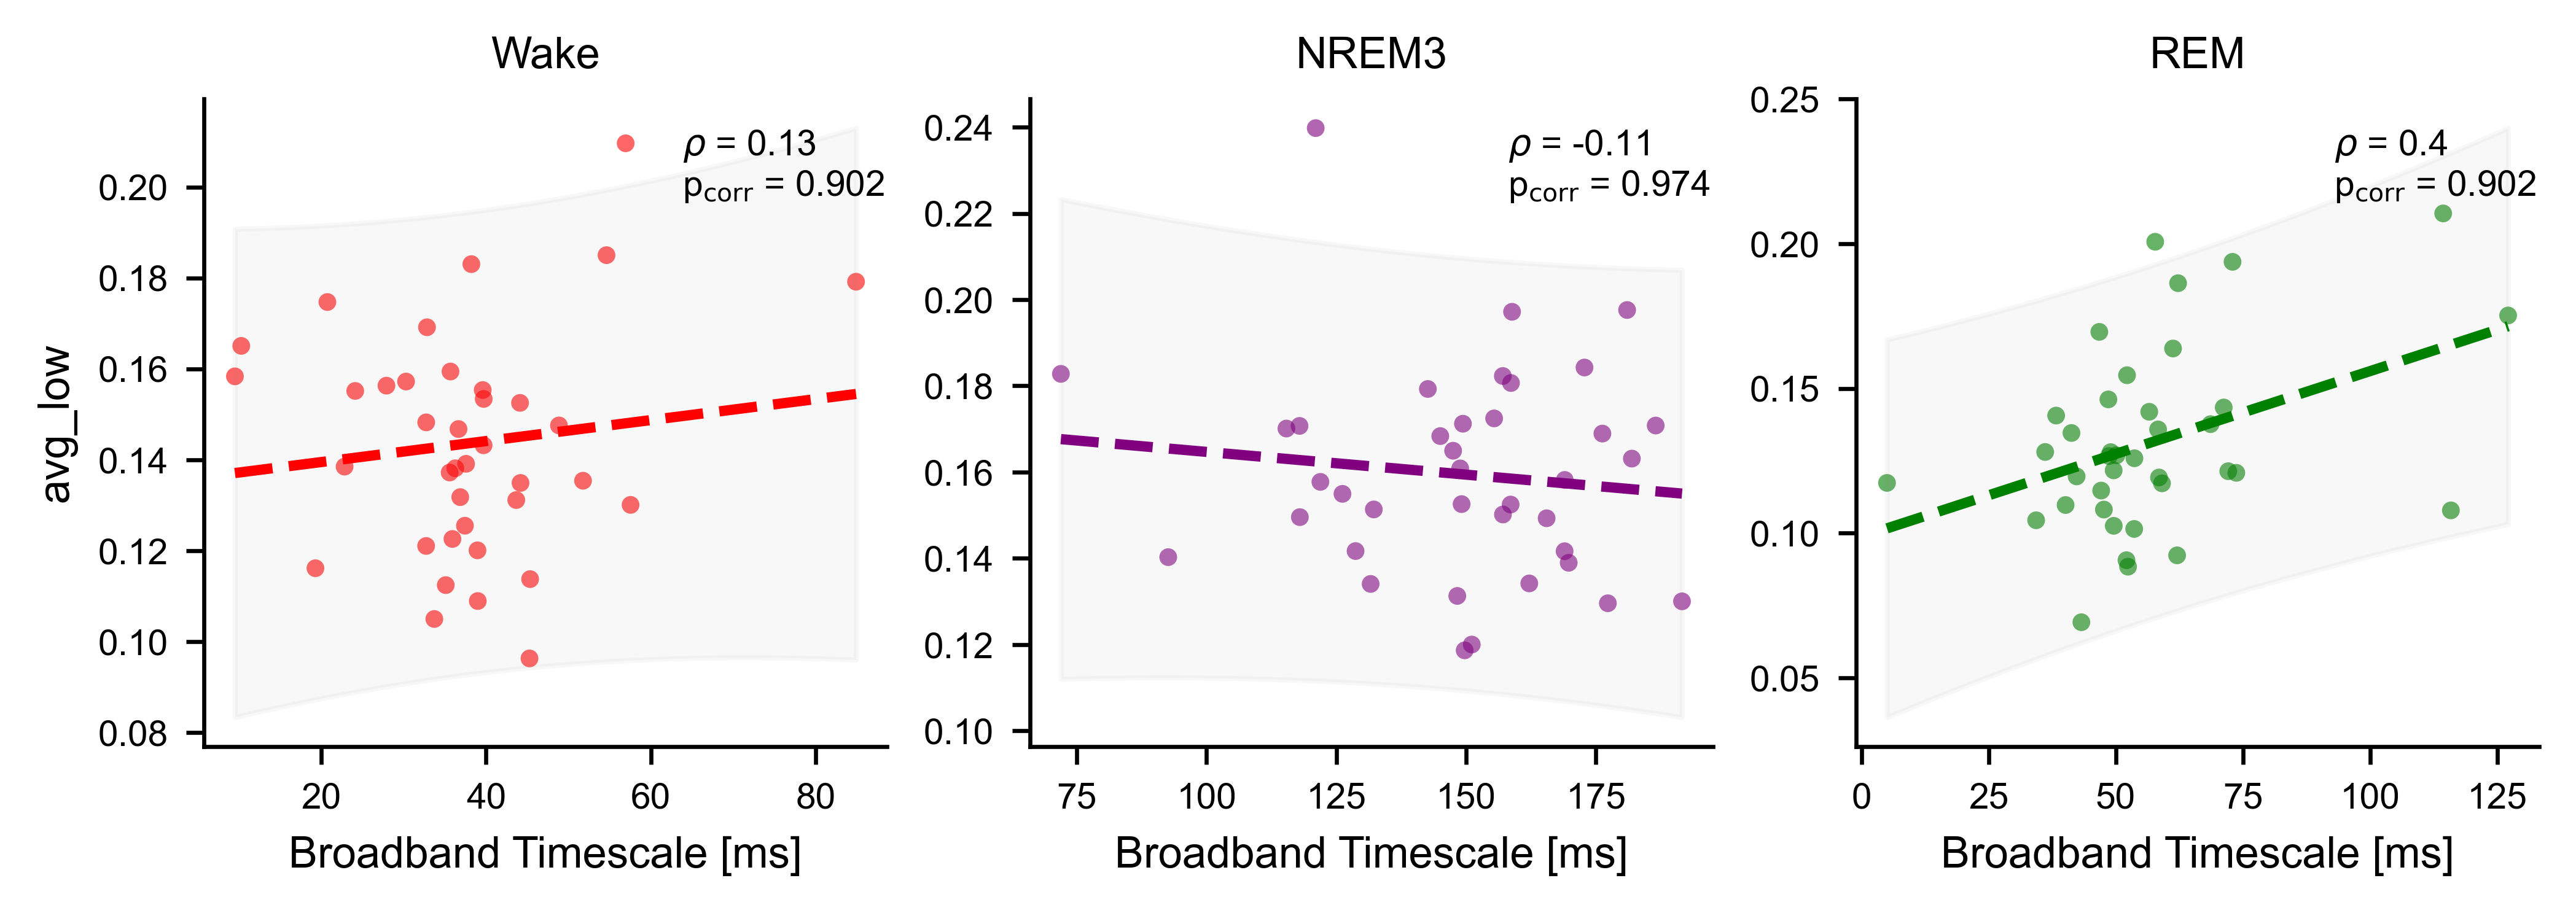

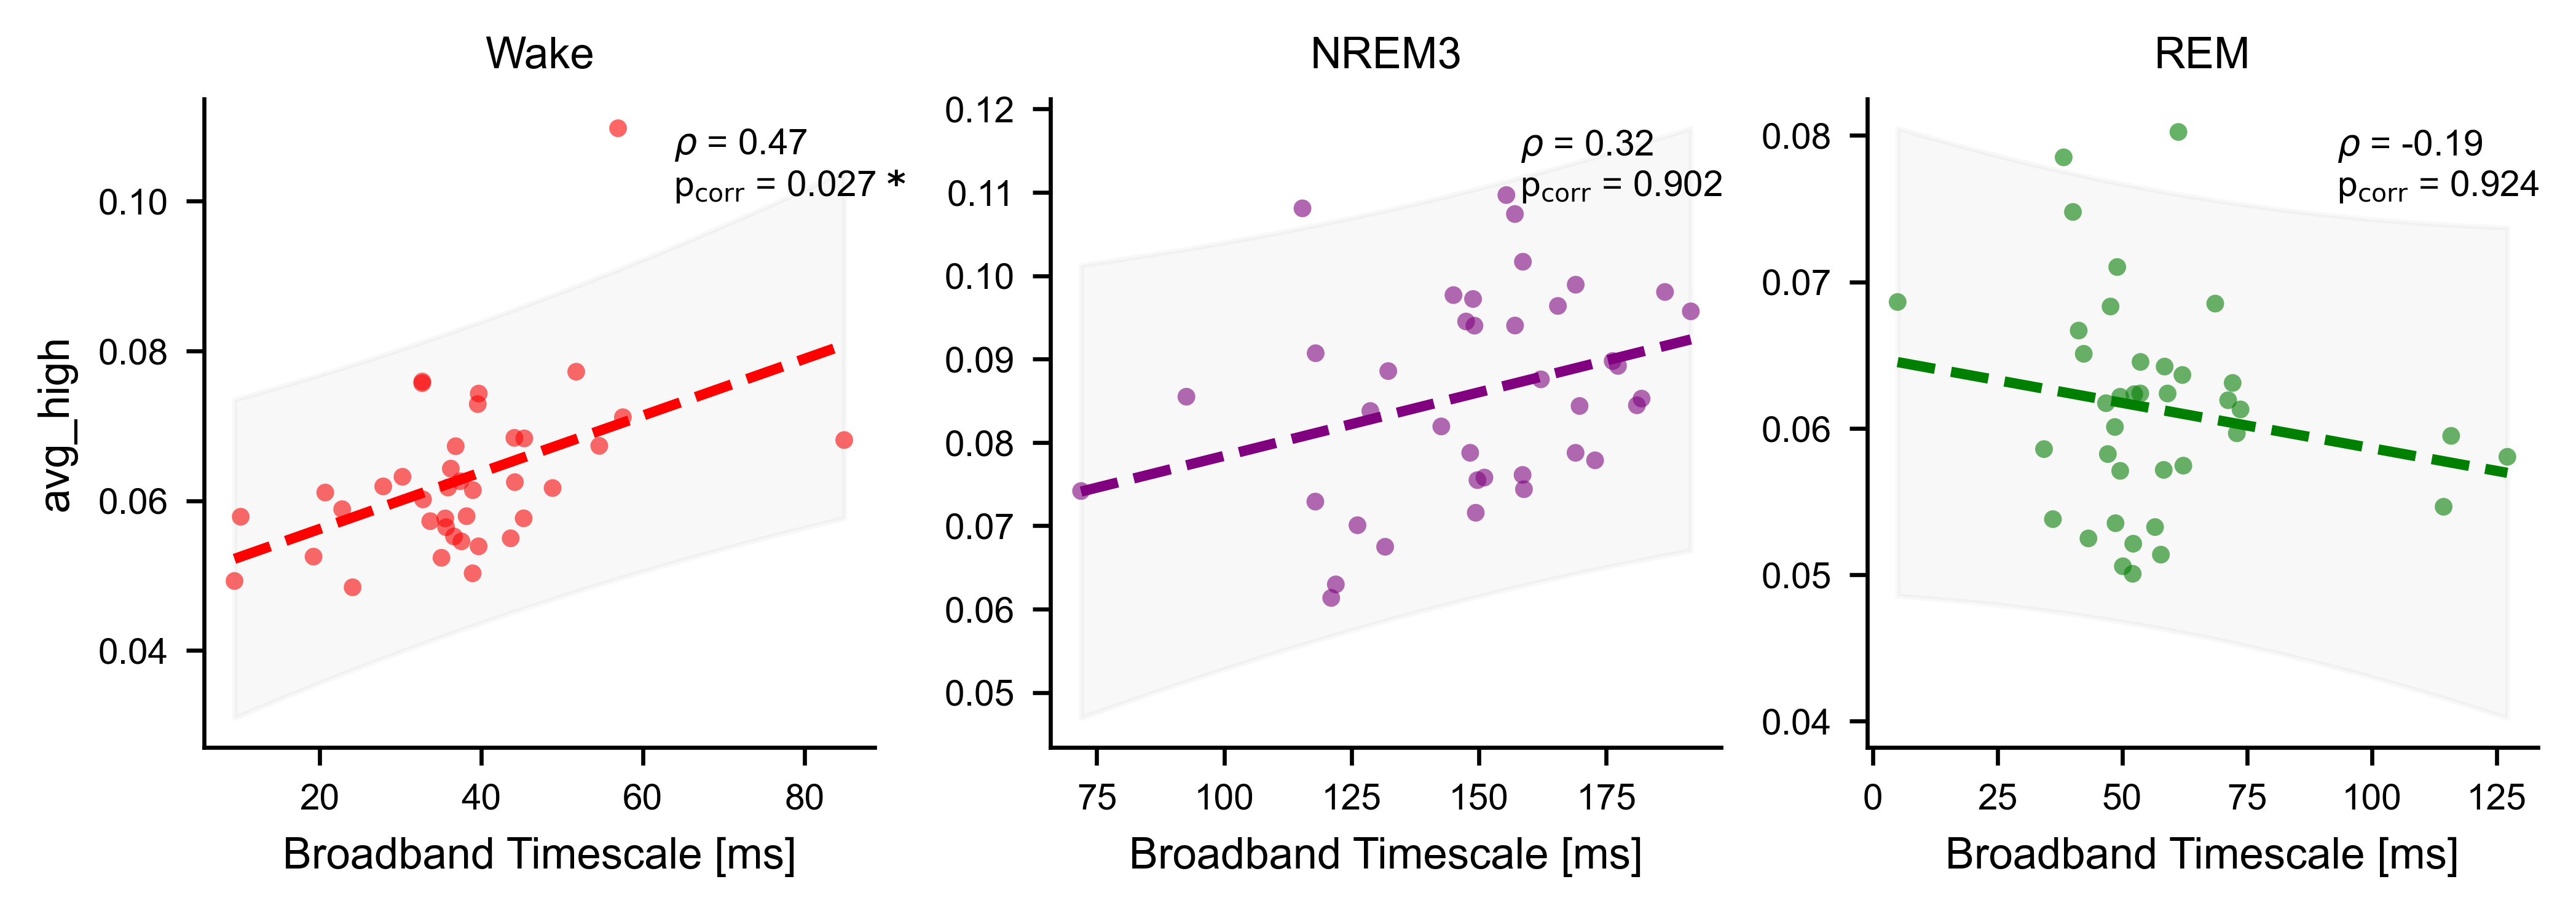

In [18]:
for param in ["avg", "avg_low", "avg_high"]:

    # Define figure
    fig, axs = plt.subplots(
        1,
        3,
        figsize=plots._get_figsize_inches((17.5, 6)),
        dpi=600,
        layout="constrained",
    )

    # One subplot per stage
    for i, stage in enumerate(stages):

        # Get average tau per MNI region
        df_tau_stage_mni = utils.get_avg_tau_mni(
            df_timescales[df_timescales["stage"] == stage].copy(), method="LME"
        )

        # Get spatial parameter
        df_spa = df_params_corr_avg_stages[stage][param].iloc[1:].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Plot
        axs[i] = plots.plot_corr(
            axs[i],
            df_tau_stage_mni.to_numpy().squeeze(),
            df_spa.to_numpy().squeeze(),
            df_rhos.loc[param, stage],
            df_pvals_corr.loc[param, stage],
            color=stage_colors[stage],
            title=title_dict[stage],
            xlabel="Broadband Timescale [ms]",
            ylabel=param,
        )
        if i > 0:
            axs[i].set_ylabel("", fontsize=0)

    plt.show()

Exactly the same result as for the b parameter. The result is expected, since that paramter should capture exactly the same information as the long-range correlation values.

### S2) Brain maps (TO DO)

Hippocampus and Amygdala surface:

In [ ]:
surface_hip_amy = nisurf.load_surf_mesh(
    data_path.joinpath("Data", "Surface", "Hip_Amy.surf.gii")
)
surface_hip_amy = utils.project_hemis_surf(surface_hip_amy, hemis="left")

Harvard-Oxford dataset for subcortical structures:

In [ ]:
HO_atlas = nilearn.datasets.fetch_atlas_harvard_oxford(
    "sub-maxprob-thr50-1mm", symmetric_split=False
)

In [ ]:
data_plot = {}

# Prepare data for plotting
for stage in ["W", "N3", "R"]:

    # Select dataframe for the stage for MNI regions
    df_stage_mni = df_sc_params_mni_stages[stage].copy()

    # Convert to Destrieux regions
    df_stage_dest = df_mnia_dest.copy()
    df_stage_dest.dropna(inplace=True)
    df_stage_dest["b"] = df_stage_mni.loc[
        df_stage_dest["MNIA"].to_list(), "b"
    ].to_list()
    df_stage_dest = df_stage_dest[["Destrieux", "b"]].groupby("Destrieux").mean()

    # Create parcellation on cortex
    N_vert = max([max(label.vertices) for label in labels_mne])
    dest_plot_parc = np.zeros((N_vert + 1), dtype=int)
    parc_names = [label.name[:-3] for label in labels_mne]
    for i, (name, label) in enumerate(zip(parc_names, labels_mne)):
        if name in df_stage_dest.index:
            dest_plot_parc[label.vertices] = i + 1

    # Select data for plot and limits
    data_plot[stage] = df_stage_dest.loc[parc_names[:-1]].to_numpy().squeeze()

In [ ]:
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}
lims_plot = {"W": [0.03, 0.07], "N3": [0.045, 0.095], "R": [0.035, 0.065]}

for stage in ["W", "N3", "R"]:
    # Plot on cortex
    fig, ax = plot_parcellated_metric(
        data_plot[stage],
        dest_plot_parc,
        subjects_dir,
        labels_mne,
        log_scale=False,
        minmax=lims_plot[stage],
        title=title_dict[stage],
        cmap="viridis",
        label="b parameter [a.u.]",
        cbar_format="3f",
    )
    fig.savefig(
        fig_path.joinpath("Fig_3", f"Fig_3_b_mni_parc_{stage}_ctx.svg"), format="svg"
    )
    plt.close(fig)

    # Plot on hippocampus and amygdala
    surface_nodes_labels = uti.get_hip_amy_vtx(HO_atlas, surface_hip_amy)
    val_amy = df_stage_mni.loc["Amygdala", "b"]
    val_hip = df_stage_mni.loc["Hippocampus", "b"]
    fig = plot_hip_amy(
        surface_hip_amy,
        val_hip,
        val_amy,
        surface_nodes_labels,
        lims_plot[stage],
        cmap="viridis",
    )
    fig.write_image(
        fig_path.joinpath("Fig_3", f"Fig_3_b_mni_parc_{stage}_hipamy.svg"),
        format="svg",
    )

Differences:

In [ ]:
data_plot_W_N3 = data_plot["N3"] - data_plot["W"]
data_plot_W_R = data_plot["R"] - data_plot["W"]

In [ ]:
# N3 - W
# Plot on cortex
fig, ax = plot_parcellated_metric(
    data_plot_W_N3,
    dest_plot_parc,
    subjects_dir,
    labels_mne,
    log_scale=False,
    minmax=(0.006, 0.031),
    zero_center=False,
    title="NREM3 - Wake",
    cmap="Reds",
    label="b parameter difference [a.u.]",
    cbar_format="3f",
)
fig.savefig(fig_path.joinpath("Fig_3", f"Fig_3_b_mni_parc_N3-W_ctx.svg"), format="svg")
plt.close(fig)
# Plot on hippocampus and amygdala
surface_nodes_labels = uti.get_hip_amy_vtx(HO_atlas, surface_hip_amy)
val_amy = df_stage_mni.loc["Amygdala", "b"]
val_hip = df_stage_mni.loc["Hippocampus", "b"]
fig = plot_hip_amy(
    surface_hip_amy, val_hip, val_amy, surface_nodes_labels, (0.006, 0.031), cmap="Reds"
)
fig.write_image(
    fig_path.joinpath("Fig_3", f"Fig_3_b_mni_parc_N3-W_hipamy.svg"),
    format="svg",
)

# R - W
# Plot on cortex
fig, ax = plot_parcellated_metric(
    data_plot_W_R,
    dest_plot_parc,
    subjects_dir,
    labels_mne,
    log_scale=False,
    minmax=(-0.012, 0.021),
    zero_center=True,
    title="REM - Wake",
    cmap="bwr",
    label="b parameter difference [a.u.]",
    cbar_format="3f",
)
fig.savefig(fig_path.joinpath("Fig_3", f"Fig_3_b_mni_parc_R-W_ctx.svg"), format="svg")
plt.close(fig)
# Plot on hippocampus and amygdala
surface_nodes_labels = uti.get_hip_amy_vtx(HO_atlas, surface_hip_amy)
val_amy = df_stage_mni.loc["Amygdala", "b"]
val_hip = df_stage_mni.loc["Hippocampus", "b"]
fig = plot_hip_amy(
    surface_hip_amy,
    val_hip,
    val_amy,
    surface_nodes_labels,
    (-0.012, 0.021),
    cmap="Reds",
)
fig.write_image(
    fig_path.joinpath("Fig_3", f"Fig_3_b_mni_parc_R-W_hipamy.svg"),
    format="svg",
)